# Massive Text Embedding Benchmark


https://huggingface.co/datasets/mteb/tweet_sentiment_extraction

In [135]:
from datasets import load_dataset
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("mteb/tweet_sentiment_extraction")

In [136]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 26732
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3432
    })
})

In [137]:
#Explore the dataset
ds['train'][0]

{'id': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'label': 1,
 'label_text': 'neutral'}

In [138]:
label_map = {str(lbl): lbl_txt for lbl, lbl_txt in zip(ds['train']['label'], ds['train']['label_text'])}
label_map

{'1': 'neutral', '0': 'negative', '2': 'positive'}

# Training a SentencePiece Tokenizer

In [139]:
import json
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in ds["train"]:
        words = line['text']
        f.write(words + "\n")

In [140]:
import sentencepiece as spm
import json
import os


options = dict(
  input="corpus.txt",
  input_format="text",
  model_prefix="simple_nn_tok",
  model_type="bpe",
  vocab_size=2048,
  byte_fallback=True,
  num_threads=os.cpu_count()
)

spm.SentencePieceTrainer.train(**options);



sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: text
  model_prefix: simple_nn_tok
  model_type: BPE
  vocab_size: 2048
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 12
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 1
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  di

In [141]:
sp = spm.SentencePieceProcessor()
sp.load('simple_nn_tok.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab[1000:1020]

[['ited', 1000],
 ['▁away', 1001],
 ['▁left', 1002],
 ['▁mothers', 1003],
 ['ily', 1004],
 ['oke', 1005],
 ['▁late', 1006],
 ['gg', 1007],
 ['hes', 1008],
 ['ner', 1009],
 ['url', 1010],
 ['▁Hope', 1011],
 ['?!', 1012],
 ['ire', 1013],
 ['▁bu', 1014],
 ['▁em', 1015],
 ['▁sha', 1016],
 ['▁6', 1017],
 ['inking', 1018],
 ['▁Twitter', 1019]]

# Train Test Split

In [142]:
train_text = ds['train']['text'][:-1000]
train_labels = ds['train']['label'][-1000:]
val_text= ds['train']['text'][1000:]
val_labels = ds['train']['label'][1000:]

In [143]:
tokenized_train_text = [sp.encode(text) for text in train_text]
tokenized_val_text = [sp.encode(text) for text in val_text]

In [144]:
nwords = len(sp)
ntags = 3 # Keep in mind that we have 3 different labels: 0, 1, 2

# Create the Embedding Layer

First we will see the one hot encoding Then we will create the embedding layer

In [ ]:
!pip install torch

In [145]:
import torch

In [146]:
print(tokenized_train_text[0])

[273, 1989, 1974, 356, 339, 1191, 902, 305, 1990, 584, 273, 751, 485]


In [147]:
import torch.nn.functional as F
x = torch.tensor(tokenized_train_text[0], dtype=torch.long)  # (T,)
one_hot = F.one_hot(x, num_classes=nwords).float()            # (T, nwords)
print(one_hot)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [148]:
one_hot.shape

torch.Size([13, 2048])

In [149]:
import torch.nn as nn

weight = nn.Parameter(torch.randn(nwords, 64))
weight

Parameter containing:
tensor([[-0.9097,  1.7696,  1.1009,  ..., -1.0958,  1.4978,  1.4665],
        [-1.2282,  0.9466,  0.4425,  ...,  0.3122,  0.2632,  0.3549],
        [ 0.0722, -0.0145, -1.9587,  ...,  0.2744, -0.1378, -0.4274],
        ...,
        [-1.9507,  2.2804,  1.6719,  ...,  0.9264,  0.0215,  0.2922],
        [-1.4360, -0.3284, -0.8601,  ..., -2.1072, -1.2789, -1.4248],
        [-0.6170, -0.1321,  0.4545,  ...,  0.7242,  1.1269,  0.4968]],
       requires_grad=True)

In [150]:
weight.shape

torch.Size([2048, 64])

In [151]:
xs = F.one_hot(x, num_classes=nwords)[:5]

xs is a vector of token IDs like [273, 1989, 1974, 356, 339, ...] and nwords is the vocabulary size (say 2000),

In [152]:
xs.shape

torch.Size([5, 2048])

In [153]:
torch.matmul(xs.float(), weight).shape

torch.Size([5, 64])

# Equivalent (and faster) form

You can skip the one-hot and directly use nn.Embedding:

In [154]:
import torch.nn as nn

embedding = nn.Embedding(num_embeddings=nwords, embedding_dim=64)
out = embedding(x[:5])
print(out.shape)  # torch.Size([5, 64])


torch.Size([5, 64])


In [156]:
class Simple_NN(torch.nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(Simple_NN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, num_labels)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, tokens):
        emb = self.embedding(tokens)
        out = torch.sum(emb, dim=0)
        logits = out.view(1, -1)
        return logits



In [155]:
#Cross Entropy Loss Function
def ce_loss(logits, target):
    log_probs = torch.nn.functional.log_softmax(logits, dim=1)
    loss = -log_probs[:, target]
    return loss

You can use the SGD (Stochastic Gradient Descent) optimizer that was introduced in class, or this typically better optimizer Adam (we'll see it in a later class).

In [157]:
train_data = list(zip(tokenized_train_text, train_labels))
val_data   = list(zip(tokenized_val_text,   val_labels))

In [158]:
import random
import time

# initialize the model
model = Simple_NN(nwords, ntags)
criterion = ce_loss
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for ITER in range(5):
    # Perform training
    random.shuffle(train_data)
    train_loss = 0.0
    start = time.time()
    for x, y in train_data:
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor([y])
        logits = model(x)
        loss = criterion(logits, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("iter %r: train loss/sent=%.4f, time=%.2fs" % (
                ITER, train_loss/len(train_data), time.time()-start))
    # Perform validation
    test_correct = 0.0
    for x, y in val_data:
        x = torch.tensor(x, dtype=torch.long)
        logits = model(x)[0].detach()
        predict = logits.argmax().item()
        if predict == y:
            test_correct += 1
    print("iter %r: valid acc=%.4f" % (ITER, test_correct/len(val_data)))



iter 0: train loss/sent=1.1027, time=0.54s
iter 0: valid acc=0.3692
iter 1: train loss/sent=1.0019, time=0.62s
iter 1: valid acc=0.3521
iter 2: train loss/sent=0.9182, time=0.56s
iter 2: valid acc=0.3564
iter 3: train loss/sent=0.8462, time=0.54s
iter 3: valid acc=0.3447
iter 4: train loss/sent=0.7839, time=0.56s
iter 4: valid acc=0.3450


In [159]:
import tiktoken

enc = tiktoken.get_encoding("gpt2")

In [160]:
data=list(zip([enc.encode(text) for text in ds['train']['text']], ds['train']['label']))

In [161]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [162]:
nwords = nwords = enc.n_vocab
ntags = 3 # Keep in mind that we have 3 different labels: 0, 1, 2


# CBOW model for word2vec

In [163]:
data=list(zip([sp.encode(text) for text in ds['train']['text']], ds['train']['label']))

In [164]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [165]:
nwords = len(sp)
ntags = 3 # Keep

In [166]:
class CBoW(torch.nn.Module):
    def __init__(self, vocab_size, num_labels, emb_size):
        super(CBoW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.output_layer = nn.Linear(emb_size, num_labels)

        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, tokens):
        emb = self.embedding(tokens)    # [len(tokens) x emb_size]
        emb_sum = torch.sum(emb, dim=0) # [emb_size]
        h = emb_sum.view(1, -1)         # [1 x emb_size]
        logits = self.output_layer(h)   # [1 x num_labels]
        return logits

In [169]:
EMB_SIZE=32
model = CBoW(nwords, ntags, EMB_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for ITER in range(1):
    random.shuffle(train_data)
    train_loss = 0.0
    start = time.time()
    model.train()
    for x, y in train_data:
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor([y])
        logits = model(x)
        loss = criterion(logits, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("iter %r: train loss/sent=%.4f, time=%.2fs" % (
                ITER, train_loss/len(train_data), time.time()-start))
    model.eval()
    # Perform testing
    test_correct = 0.0
    for x, y in val_data:
        x = torch.tensor(x, dtype=torch.long)
        logits = model(x)[0].detach()
        predict = logits.argmax().item()
        if predict == y:
            test_correct += 1
    print("iter %r: validation acc=%.4f" % (ITER, test_correct/len(val_data)))

iter 0: train loss/sent=0.8531, time=41.09s
iter 0: validation acc=0.6626


In [171]:
tweet = "I hate NLP!"
tokens = torch.tensor(sp.encode(tweet), dtype=torch.long)
logits = model(tokens)[0].detach()
predict = logits.argmax().item()
predict

0

In [172]:
label_map[str(predict)]

'negative'

# Visualizing embeddings (fixed, PyTorch + tiktoken)

This will:

Grab the trained embedding matrix from the PyTorch model,

PCA to 2D,

Plot the most frequent tokens found in your training data (to keep the plot readable),

Decode tokens with tiktoken (note: GPT-2 BPE tokens are often subword pieces; many start with a leading space).

In [173]:
import numpy as np

In [174]:
import math, string
from collections import Counter, defaultdict

# --- define stopword set and helper function ---
stop_words = {
    "the","a","an","and","or","to","of","in","on","at","for","is","it","this",
    "that","with","as","by","from","are","was","be","were","so","if","but","not",
    "i","you","he","she","we","they","me","my","your","our","their", "good", "too", "like"
}

def is_meaningful(tok):
    """Return True if token is not punctuation/stopword/empty."""
    text = enc.decode([tok]).strip().lower()
    if not text or all(ch in string.punctuation for ch in text):
        return False
    if text in stop_words:
        return False
    return True

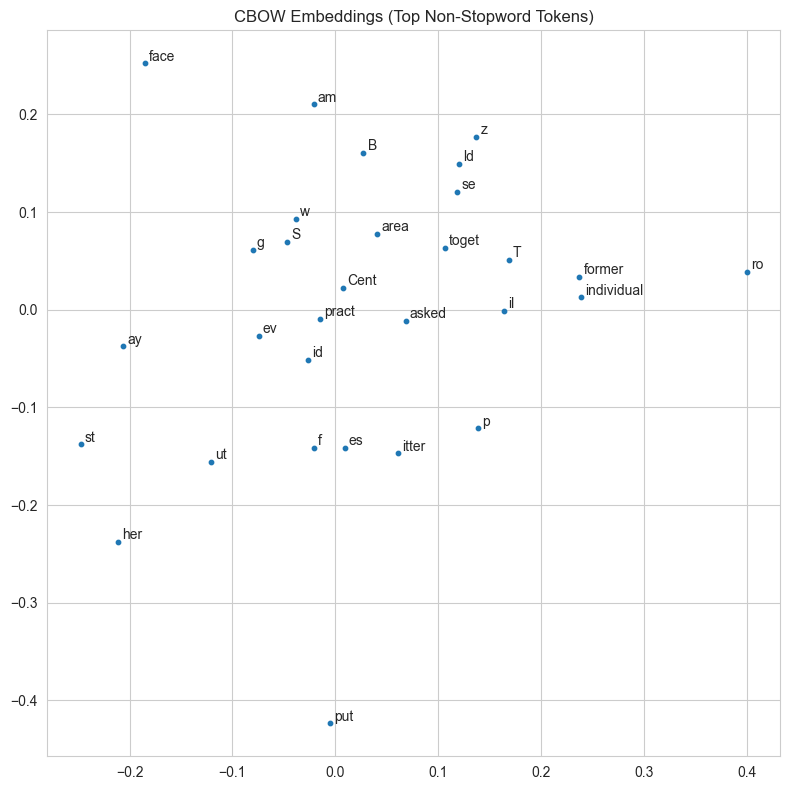

In [175]:
# --- Pure PyTorch PCA + Matplotlib (no .numpy())
import matplotlib.pyplot as plt
from collections import Counter
import torch
import math
from collections import defaultdict
freq = Counter()
for x_ids, _ in train_data:
    freq.update(x_ids)

# take top-N among most-common after simple filter
N = 30
top_tokens = [tok for tok, _ in freq.most_common(1000) if is_meaningful(tok)][:N]

# 2) PCA with pure torch (no numpy/sklearn)
with torch.no_grad():
    E = model.embedding.weight.detach().cpu()            # [vocab, emb_dim]
    E_centered = E - E.mean(dim=0, keepdim=True)
    U, S, V = torch.pca_lowrank(E_centered, q=2)
    reduced = E_centered @ V[:, :2]                      # [vocab, 2]

# 3) plot
xs = reduced[top_tokens, 0].tolist()
ys = reduced[top_tokens, 1].tolist()

plt.figure(figsize=(8, 8))
plt.scatter(xs, ys, s=10)

for tok, x, y in zip(top_tokens, xs, ys):
    label = enc.decode([tok]).replace("\n", " ").strip() or f"␀{tok}"
    plt.annotate(label, xy=(x, y), xytext=(3, 2), textcoords="offset points")

plt.title("CBOW Embeddings (Top Non-Stopword Tokens)")
plt.tight_layout()
plt.show()